In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/platesv2/sample_submission.csv
/kaggle/input/platesv2/plates.zip


# Gerekli Kütüphanlerin Yüklenmesi

In [2]:
import os
import cv2
import zipfile
import numpy as np
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import torch
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import AdamW

# Zip Dosyasından Verileri Çıkartma ve DataFrame Oluşturma

In [3]:
with zipfile.ZipFile('/kaggle/input/platesv2/plates.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/')

img_path = "/kaggle/working/plates/train/"
labels = ['cleaned', 'dirty']

def set_df(dir):
    img_list = []
    label_list = []
    
    for label in labels:
        label_dir = os.path.join(dir, label)
        if not os.path.exists(label_dir):
            print(f"Error: {label_dir} does not exist.")
            continue
        
        for img_file in os.listdir(label_dir):
            if img_file.endswith('.jpg'):
                img_list.append(label_dir + "/" + img_file)
                label_list.append(label)
    
    df = pd.DataFrame({"img": img_list, "label": label_list})
    print(f"DataFrame {len(df)} giriş ile oluşturuldu.")
    return df



# DataFrame oluşturma
df = set_df(img_path)


DataFrame 40 giriş ile oluşturuldu.


# Kod Görsellerini ve Etiketlerini Kontrol Etme

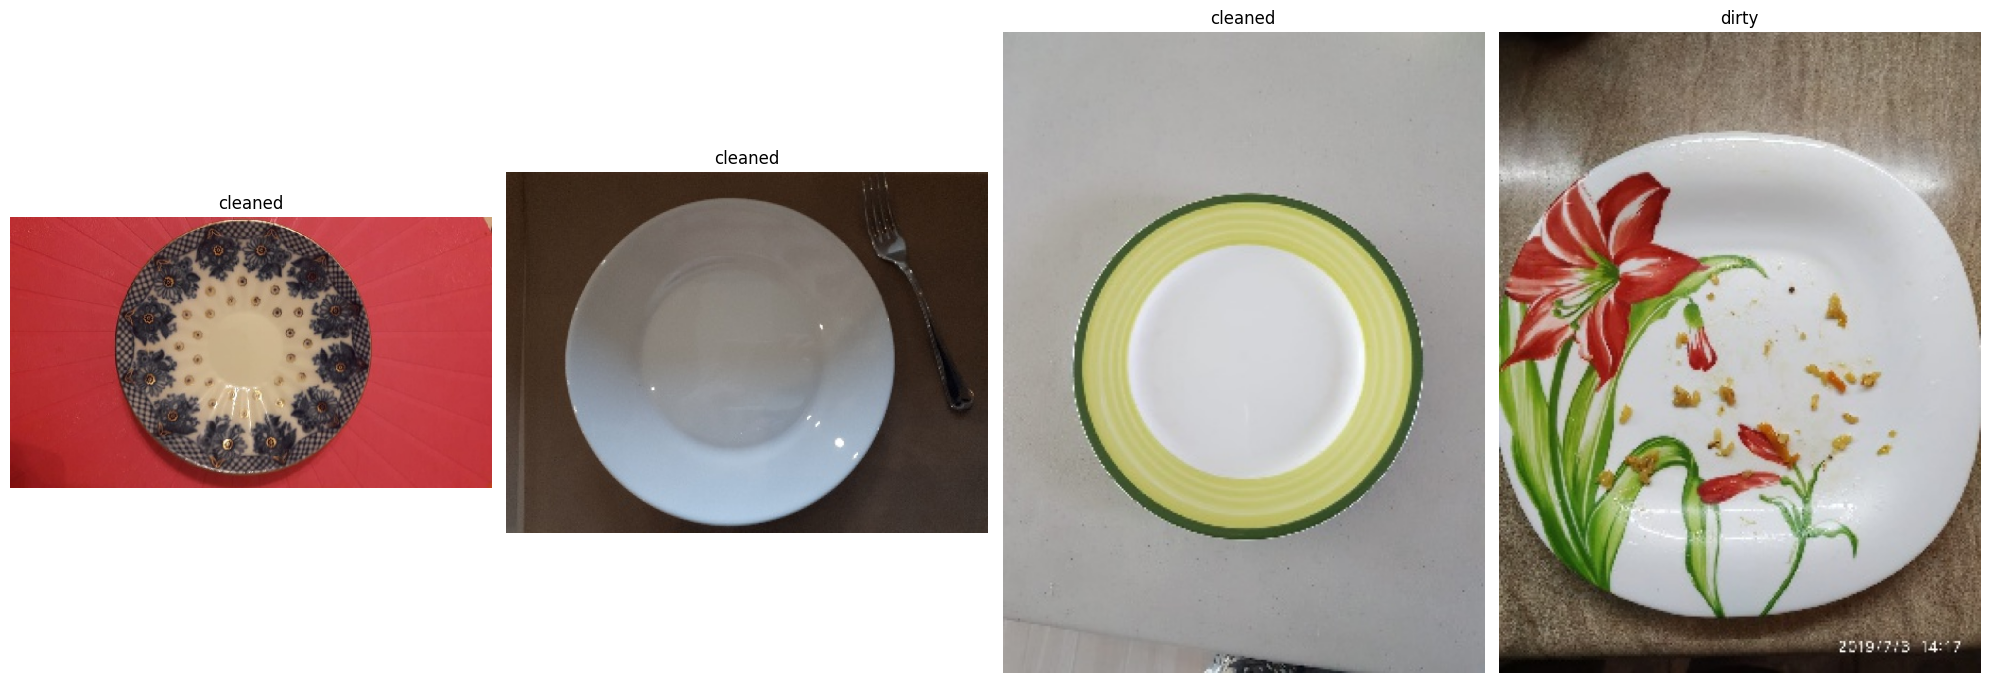

In [4]:
def show_random_images(df, num_samples=4):
    # Veri setinden rastgele örnekler seç
    random_samples = df.sample(n=num_samples, random_state=42)  # Sabit sonuçlar için random_state eklenebilir
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 10))
    
    # Rastgele seçilen görselleri ve etiketlerini göster
    for i, (img_path, label) in enumerate(zip(random_samples['img'], random_samples['label'])):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Rastgele 4 görseli göster
show_random_images(df, num_samples=4)

# Etiketlerin Sayısal Değerlere Dönüştürülmesi

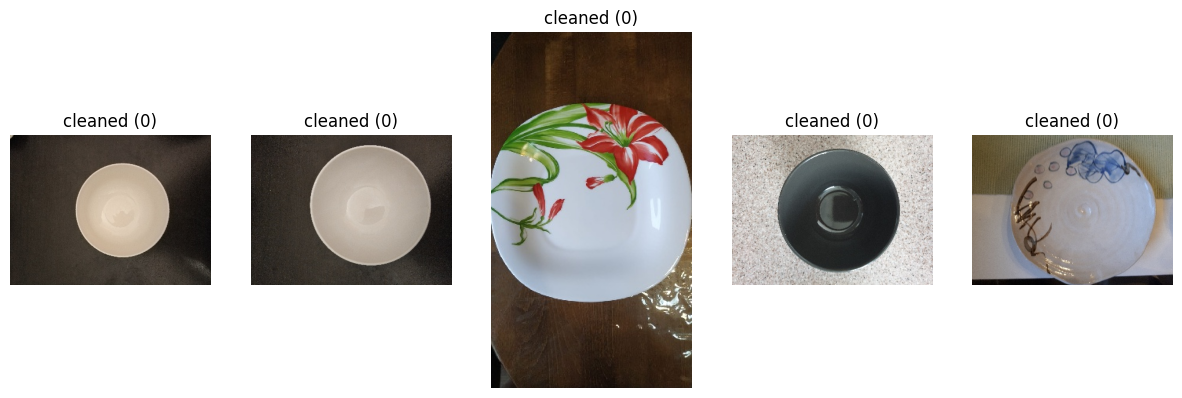

In [5]:
# Etiketleri sayısal hale getirme
d = {"dirty": 1, "cleaned": 0}
df["encode_label"] = df["label"].map(d)

# Görsellerin görselleştirilmesi (Etiket ve sayısal karşılıkla birlikte)
def show_images(df):
    fig, axes = plt.subplots(1, 5, figsize=(15, 15))
    for i, (img_path, label, encoded_label) in enumerate(zip(df['img'][:5], df['label'][:5], df['encode_label'][:5])):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{label} ({encoded_label})')  # Etiketi ve sayısal karşılığını başlık olarak göster
        axes[i].axis('off')
    plt.show()

show_images(df)

# İlk ve Son 5 Verinin Kontrolü

In [6]:
df.head(5)


,img,label,encode_label
0,/kaggle/working/plates/train/cleaned/0010.jpg,cleaned,0
1,/kaggle/working/plates/train/cleaned/0002.jpg,cleaned,0
2,/kaggle/working/plates/train/cleaned/0007.jpg,cleaned,0
3,/kaggle/working/plates/train/cleaned/0003.jpg,cleaned,0
4,/kaggle/working/plates/train/cleaned/0016.jpg,cleaned,0


In [7]:
df.tail(5)

,img,label,encode_label
35,/kaggle/working/plates/train/dirty/0017.jpg,dirty,1
36,/kaggle/working/plates/train/dirty/0015.jpg,dirty,1
37,/kaggle/working/plates/train/dirty/0004.jpg,dirty,1
38,/kaggle/working/plates/train/dirty/0014.jpg,dirty,1
39,/kaggle/working/plates/train/dirty/0008.jpg,dirty,1


# Her Label İçin Kaç Görsel Olduğunu Belirleme

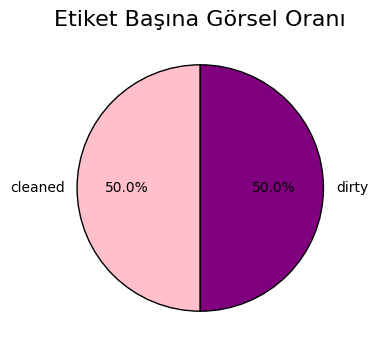

In [8]:
label_counts = df['label'].value_counts()

# Pasta grafiği
plt.figure(figsize=(4, 4))
label_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['pink', 'purple'], wedgeprops={'edgecolor': 'black'})
plt.title('Etiket Başına Görsel Oranı', fontsize=16)
plt.ylabel('')  
plt.show()

# Görüntü İşleme

In [9]:
# Görüntü işleme dönüşümleri
transform_augment = transforms.Compose([
    transforms.Resize((128, 128)),  # Görüntü boyutunu ayarla
    transforms.ToTensor(),# Görüntüyü tensöre dönüştür
    transforms.RandomHorizontalFlip(),  # Yatay çevirme
    transforms.RandomRotation(10),  # Rastgele döndürme
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Renk yoğunluğu değişimi
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize et
])

# Dataset sınıfı
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Görselin yolunu al
        image = Image.open(img_path)  # Görseli aç

        if self.transform:
            image = self.transform(image)  # Görsel üzerinde dönüşüm uygula

        label = self.dataframe.iloc[idx, 2]  # Etiketi al
        return image, label


In [10]:

# Eğitim seti için custom dataset
train_dataset = CustomDataset(dataframe=df, transform=transform_augment)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


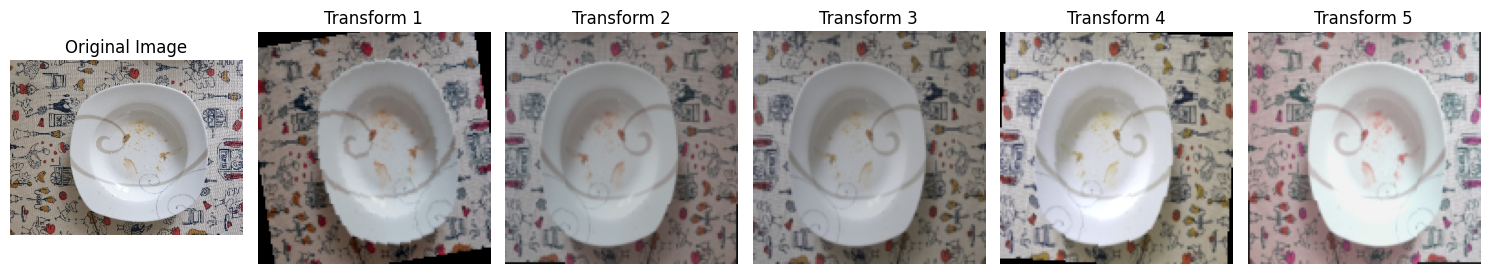

In [11]:

import random

def visualize_augmentations(dataset, index, n_transforms=5):
   
    # Orijinal görüntüyü al
    img_path = dataset.dataframe.iloc[index, 0]
    original_image = Image.open(img_path)
    
    # Görselleştirme başlat
    plt.figure(figsize=(15, 5))
    plt.subplot(1, n_transforms + 1, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")
    
    # Dönüşümlerin uygulanmış hallerini görselleştir
    for i in range(n_transforms):
        transformed_image, _ = dataset[index]  # Dönüşüm uygulanmış görüntüyü al
        transformed_image = transformed_image.permute(1, 2, 0)  # Kanal sıralamasını düzenle (CHW -> HWC)
        transformed_image = (transformed_image * 0.5 + 0.5).clip(0, 1)  # Normalize dönüşümünü tersine çevir
        
        plt.subplot(1, n_transforms + 1, i + 2)
        plt.imshow(transformed_image)
        plt.title(f"Transform {i + 1}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

random_index = random.randint(0, len(train_dataset) - 1)
visualize_augmentations(train_dataset, index=random_index, n_transforms=5)


In [12]:


# Önceden eğitilmiş ResNet18 modelini yükleme 
from torchvision.models import ResNet18_Weights

# Modeli yükle ve ağırlıkları güncel yönteme göre al
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Çıkış katmanını değiştirme (2 sınıf için)
model.fc = nn.Linear(model.fc.in_features, 2) 

# Modeli cihaz (GPU veya CPU) üzerine gönder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


# Sınıflandırma

In [13]:

criterion = nn.CrossEntropyLoss()  
optimizer = AdamW(model.parameters(), lr=0.001)  
train_losses = []
train_accuracies = []
# Eğitim döngüsü
epochs = 5
for epoch in range(epochs):
    model.train()  # Modeli eğitim moduna al
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  
        
        outputs = model(inputs)  # Modelden tahmin al
        loss = criterion(outputs, labels)  # Kayıp hesapla
        loss.backward()  
        optimizer.step()  
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # En yüksek olasılığa sahip sınıfı al
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)  # Kayıp değerini sakla
    train_accuracies.append(epoch_accuracy)  # Doğruluk değerini sakla
    
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


Epoch 1/5, Loss: 0.6125, Accuracy: 65.00%
Epoch 2/5, Loss: 1.8968, Accuracy: 62.50%
Epoch 3/5, Loss: 0.8544, Accuracy: 90.00%
Epoch 4/5, Loss: 0.4843, Accuracy: 87.50%
Epoch 5/5, Loss: 0.3531, Accuracy: 90.00%


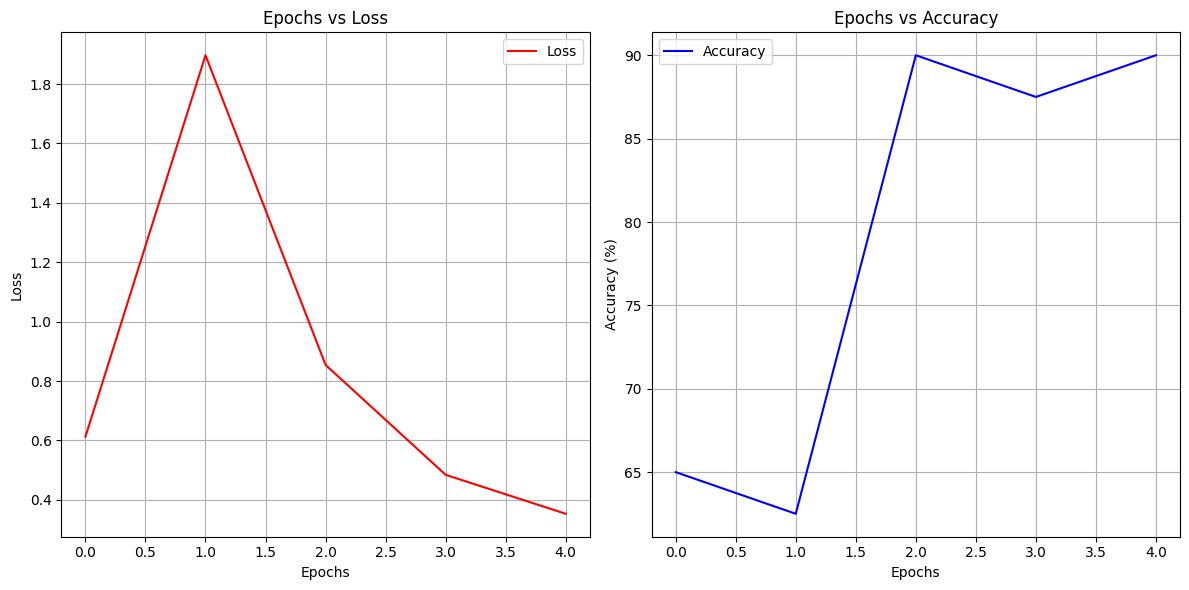

In [14]:
plt.figure(figsize=(12, 6))

# Kayıp Grafiği
plt.subplot(1, 2, 1)  
plt.plot(range(epochs), train_losses, label='Loss', color='red')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Doğruluk Grafiği
plt.subplot(1, 2, 2)  
plt.plot(range(epochs), train_accuracies, label='Accuracy', color='blue')
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()


plt.tight_layout()
plt.show()

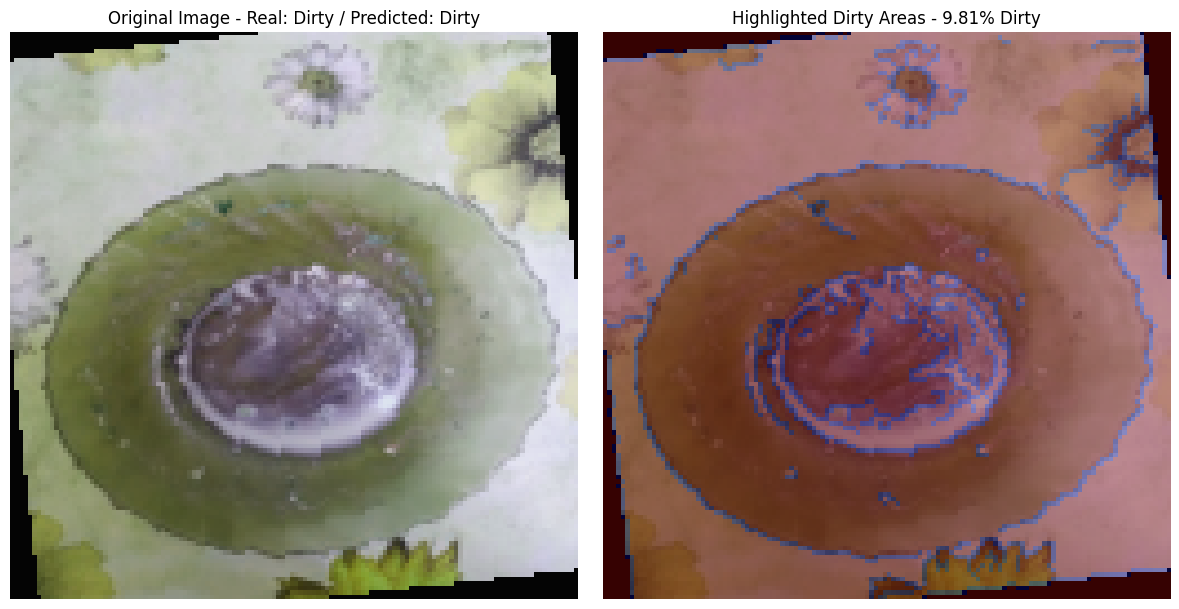

In [15]:


def highlight_dirty_areas(image_tensor, label, model):
    model.eval()  # Modeli değerlendirme moduna al
    
    # Görseli normalize dönüşümünden çıkar ve PIL formatına döndür
    original_image = to_pil_image((image_tensor * 0.5 + 0.5).clip(0, 1))
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Batch boyutu ekle ve cihaza gönder

    # Modelden çıktı al
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        prediction = "Cleaned" if predicted.item() == 0 else "Dirty"
    
    # Gerçek etiketi alalım
    real_label = "Cleaned" if label == 0 else "Dirty"
    
    # Görseli numpy formatına dönüştür
    original_image_np = np.array(original_image)
    
    # Örnek olarak edge-detection ile "kirli bölgeleri" simüle edelim
    gray_image = cv2.cvtColor(original_image_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)  # Kenar algılama (örnek kirli bölgeler)

    # Kirli alan oranını hesapla
    dirty_area = np.sum(edges != 0)  # Kenarların bulunduğu pikselleri say
    total_area = edges.size  # Görseldeki toplam piksel sayısı
    dirty_percentage = (dirty_area / total_area) * 100  # Kirli alan oranı

    # Isı haritası oluştur (örnek segmentasyon için)
    heatmap = cv2.applyColorMap(edges, cv2.COLORMAP_JET)
    heatmap = cv2.addWeighted(original_image_np, 0.6, heatmap, 0.4, 0)
    
    # Görseli ve tahminleri göster
    plt.figure(figsize=(12, 6))
    
    # Orijinal Görsel
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_np)
    plt.title(f"Original Image - Real: {real_label} / Predicted: {prediction}")
    plt.axis("off")
    
    # Kirli Alanları Göster
    plt.subplot(1, 2, 2)
    plt.imshow(heatmap)
    plt.title(f"Highlighted Dirty Areas - {dirty_percentage:.2f}% Dirty")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Örnek Görsel Seçimi
image_tensor, label = train_dataset[random.randint(0, len(train_dataset) - 1)]
highlight_dirty_areas(image_tensor, label, model)


# Gelecek Tahminleme

In [16]:


# 1. Görselleri Düzleştirme ve Özellik Vektörü Hazırlama
def flatten_images(df):
    features = []
    for img_path in df['img']:
        img = Image.open(img_path).resize((64, 64))  # Görselleri daha küçük boyuta getir
        img_array = np.array(img).flatten()  # Görseli düzleştir
        features.append(img_array)
    return np.array(features)

X = flatten_images(df)  # Özellikler
y = df['encode_label'].values  # Etiketler

# 2. Veriyi Eğitim ve Test Seti Olarak Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Lojistik Regresyon Modeli ile Eğitme
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Performansı Değerlendirme
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# 5. Gelecek Görsel Tahmini
# Test setindeki ilk görselin özelliklerini al ve bir sonraki tahmini yap
next_image = X_test[0].reshape(1, -1)  # İlk görselin özelliklerini al
predicted_label = model.predict(next_image)
print(f"Gelecek Görselin Tahmini Sınıfı: {'dirty' if predicted_label[0] == 1 else 'cleaned'}")


Test Accuracy: 0.38
Gelecek Görselin Tahmini Sınıfı: dirty
